In [1]:
import pandas as pd
import plotly.express as px
import re
import seaborn as sns
import numpy as np
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /home/marvin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### erste gedanken:

- Es ist bis Sitzung 19 komplett vorhanden
- Sitzung 20 nur teilweise bis März 2022, zur 38 sitzung

### zweite Gedanken
vielleicht können nutzer Wörter eingeben, dessen verwendung im dt bundestag sie sehen wollen, zB ORdnugsruf

- es scheint so, dass die Rufe zur Ordnung erst nach den Reden passieren
    - d.h, wenn in einer Rede der Begriff ORdnungsruf anfällt (und diese Rede vom Präsidium kommt, dann muss man diese wahrscheinlich der Partei zuprdnen, welche davor geredet hat (bzw dem politikerinnen))
    - vllt auch in der rede vom präsidium nach Namensnennungen gucken, weil eigentlich nennen die Immer einen Namen

### dritte Gedanken
- Datenbank lokal nachbauen
- https://www.bundestag.de/ajax/filterlist/de/services/opendata/1058442-1058442?limit=10&noFilterSet=true&offset=0 für wp 21
- dafür müsste man den Code anpassen in concat_everything.py und anderen Dateien, um wp 21 zu berücksichtigen, nicht nur die URL hinzufügen
- daten für wp 20 waren zwar da, aber in schon ziemlich anderem Format, ich glaube der neuste Datensatz ist leciht anders aufgebaut und eher nach dem Datensatz von pymdas oder so



In [2]:
factions = pd.read_pickle("../data/factions.pkl")
speeches = pd.DataFrame(pd.read_pickle("../data/speeches_lower.pkl"))
cont_sim = pd.DataFrame(pd.read_pickle("../data/contributions_simplified.pkl"))
cont_ext = pd.DataFrame(pd.read_pickle("../data/contributions_extended.pkl"))
# terms = pd.DataFrame(pd.read_pickle("../data/electoral_terms.pkl"))
# politicans = pd.DataFrame(pd.read_pickle("../data/politicians.pkl"))

# factions

In [3]:
speeches.groupby(["position_short"]).size()

position_short
Chancellor                   2643
Guest                       15562
Member of Parliament       380024
Minister                    46497
Not found                      33
Presidium of Parliament    390321
Secretary of State          84443
dtype: int64

In [4]:
speeches.groupby("electoral_term")["session"].max()

electoral_term
1     282
2     227
3     168
4     198
5     247
6     199
7     259
8     230
9     142
10    256
11    236
12    243
13    248
14    253
15    187
16    233
17    253
18    245
19    239
20     38
Name: session, dtype: int64

In [5]:
big_party = ["AfD","Grüne" ,"CDU/CSU","DIE LINKE." , "FDP" , "Fraktionslos", "SPD" , "SSW"]

In [6]:
speeches.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 919523 entries, 0 to 919522
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              919523 non-null  int64 
 1   session         919523 non-null  int64 
 2   electoral_term  919523 non-null  int64 
 3   politician_id   919523 non-null  int64 
 4   speech_content  919523 non-null  object
 5   faction_id      919523 non-null  int64 
 6   document_url    919523 non-null  object
 7   position_short  919523 non-null  object
 8   position_long   919523 non-null  object
 9   date            919523 non-null  object
dtypes: int64(5), object(5)
memory usage: 2.6 GB


In [7]:
# speeches2 = pd.DataFrame(pd.read_pickle("/home/marvin/Documents/open-discourse/python/data/03_final/speech_content.pkl"))

In [8]:
color_map = {
    'CDU/CSU': 'black',
    'SPD': '#E3000F',
    'Grüne': '#6AB023',
    'FDP': '#FFD700',
    'DIE LINKE.': '#BE3075',
    'AfD': '#009EE0',
}

In [9]:
# das hier wurde gemacht um erstmal alles in lowercase zu convertieren
# speeches["speech_content"] = speeches["speech_content"].str.lower()
# speeches.to_pickle("../data/speeches_lower.pkl")


In [10]:
import gc
gc.collect() 

0

In [11]:
from collections import Counter
import tqdm
# word_counter = Counter()
# for text in tqdm.tqdm(speeches["speech_content"]):
#     words = re.findall(r'\b[\wäöüÄÖÜß]+\b',text)
#     word_counter.update(words)

In [12]:
# word_counter["corona"]

In [13]:
id_to_name = dict(zip(factions['id'], factions['abbreviation']))


In [14]:
speeches["speech_length"] = speeches["speech_content"].str.len()

In [15]:
speeches["faction_name"] = speeches["faction_id"].map(id_to_name)
cont_ext["faction_name"] = cont_ext["faction_id"].map(id_to_name)

In [16]:
latex = cont_ext.groupby("type").size().to_latex()
latex

'\\begin{tabular}{lr}\n\\toprule\n & 0 \\\\\ntype &  \\\\\n\\midrule\nBeifall & 1471300 \\\\\nHeiterkeit & 19967 \\\\\nLachen & 28872 \\\\\nPersonen-Einruf & 733093 \\\\\nUnruhe & 367 \\\\\nWiderspruch & 18975 \\\\\nZuruf & 223604 \\\\\nZustimmung & 50034 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [17]:
print(latex)

\begin{tabular}{lr}
\toprule
 & 0 \\
type &  \\
\midrule
Beifall & 1471300 \\
Heiterkeit & 19967 \\
Lachen & 28872 \\
Personen-Einruf & 733093 \\
Unruhe & 367 \\
Widerspruch & 18975 \\
Zuruf & 223604 \\
Zustimmung & 50034 \\
\bottomrule
\end{tabular}



In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sentence_transformers import SentenceTransformer

/home/marvin/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
def durchschnittliche_satzlaenge(text):
    saetze = nltk.sent_tokenize(text, language="german")
    if not saetze:
        return 0
    return len(text)/len(saetze)
# nltk.download('punkt_tab')


In [20]:
# subspeeches = speeches[(speeches["electoral_term"] > 0) & (speeches["position_short"] == "Member of Parliament")]
# # subspeeches = speeches[(speeches["position_short"] == "Member of Parliament")]
subspeeches = pd.read_pickle("../data/MdB_speeches_preprocessed.pkl")
# subspeeches["faction_name"].unique()

In [21]:
# subspeeches["satzlaenge"] = subspeeches["speech_content"].apply(durchschnittliche_satzlaenge)

In [22]:
# subspeeches.to_pickle("../data/MdB_speeches_preprocessed.pkl")

In [23]:
gr = subspeeches.groupby(["electoral_term"])["satzlaenge"].mean().reset_index()

In [24]:
fig = px.bar(
    gr,
    x="electoral_term",
    y="satzlaenge",
    # color="faction_name",
    # color_discrete_map=color_map,
    labels={"electoral_term": "Wahlperiode", 
            "satzlaenge": "Länge der Sätze", 
            # "faction_name": "Fraktion", 
            "speeches" : "Reden"},
    title="Durchschnittliche Satzlänge von MdB",
)
fig.update_layout(showlegend=False)
fig.show()

### Satzlänge immer recht typisch gleich, kein wirklichen Unterschiede

In [30]:
# df_grouped = subspeeches.groupby(["faction_name"])["speech_content"].apply(lambda x: " ".join(x)).reset_index()
import re

# Nur AfD-Reden
afd_df = speeches[speeches["faction_name"] == "AfD"].copy()

# Regex-Muster: 50 Zeichen davor und danach
pattern = r".{0,50}fremdbetreuung.{0,50}"

# Ausschnitte extrahieren
afd_df["ausschnitte"] = afd_df["speech_content"].apply(
    lambda text: re.findall(pattern, text, flags=re.IGNORECASE)
)

# Nur Zeilen behalten, wo auch Treffer existieren
afd_df = afd_df[afd_df["ausschnitte"].map(len) > 0]

# Jeden Treffer in eigene Zeile auflösen
ausschnitte = afd_df.explode("ausschnitte")[["ausschnitte"]]

print(ausschnitte)



                                              ausschnitte
851486  die tatsächliche wahlfreiheit der eltern zwisc...
853917  hl haben, ob sie ihr kind selbst betreuen oder...
853917  ation gezwungen sind, ihr kind nach einem jahr...
857076  hl haben, ob sie ihr kind selbst betreuen oder...
857076  ation gezwungen sind, ihr kind nach einem jahr...
858403  dass der staat den immensen bedarf an staatlic...
858410  ufstätigkeit. finanzieren sie nicht einseitig ...
874681  den bedarf an fremdbetreuung hat der staat dur...
874681  n gründen gezwungen sein, ihre kleinkinder in ...
874681   „fremdbetreuung oder eigenbetreuung“ in den p...
874694   nicht immer mehr und mehr geld in die staatli...
874694  zierte fremdbetreuung in diesen sozialistische...
879673  m bleibt für viele unerschwinglich. den bedarf...
879673  um eine echte wahlfreiheit in der frage „fremd...
886320   von großeltern, stattdessen mit frühestmöglic...
891205  sie fordern weiterhin milliarden für die fremd...
891205  anstat

In [39]:
for a in ausschnitte["ausschnitte"]:
    print(a)

die tatsächliche wahlfreiheit der eltern zwischen fremdbetreuung und eigenbetreuung der kinder herstellen und dafü
hl haben, ob sie ihr kind selbst betreuen oder in fremdbetreuung geben.
ation gezwungen sind, ihr kind nach einem jahr in fremdbetreuung zu geben.
hl haben, ob sie ihr kind selbst betreuen oder in fremdbetreuung geben. viele mütter und väter können diese entsch
ation gezwungen sind, ihr kind nach einem jahr in fremdbetreuung zu geben.
dass der staat den immensen bedarf an staatlicher fremdbetreuung durch die hohe abgabenlast selbst verursacht hat.
ufstätigkeit. finanzieren sie nicht einseitig die fremdbetreuung, sondern stellen sie tatsächliche wahlfreiheit de
den bedarf an fremdbetreuung hat der staat durch seine abgabenlast zum großen 
n gründen gezwungen sein, ihre kleinkinder in die fremdbetreuung zu geben. um eine echte wahlfreiheit in der frage
 „fremdbetreuung oder eigenbetreuung“ in den prägenden ersten drei
 nicht immer mehr und mehr geld in die staatliche fremdbe

In [26]:
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

In [27]:
print("Max tokens:", model.get_max_seq_length())

Max tokens: 128


In [20]:
embeddings = model.encode(df_grouped["speech_content"].tolist(), show_progress_bar=True)


Batches: 100%|██████████| 1/1 [00:41<00:00, 41.82s/it]


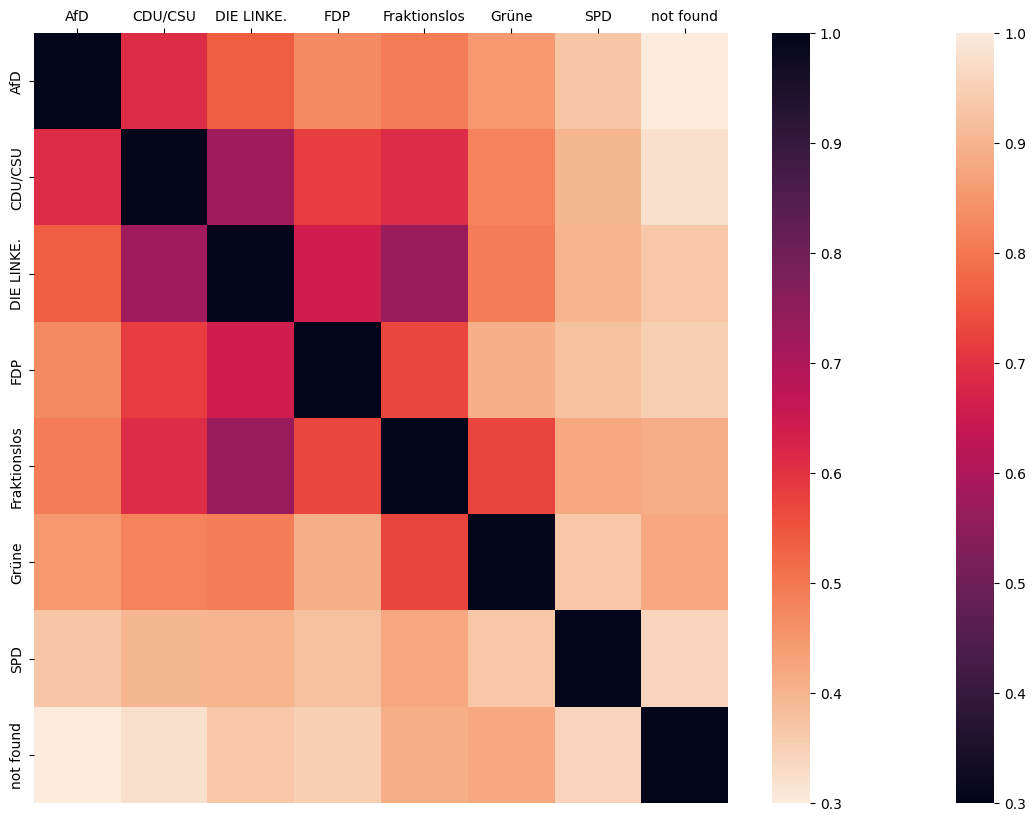

In [42]:
similarities = model.similarity(embeddings, embeddings)
plt.figure(figsize=(14,10))
sns.heatmap(similarities)
labels = df_grouped["faction_name"].tolist()
fig = sns.heatmap(
    similarities,
    xticklabels=labels,
    yticklabels=labels,
    cmap="rocket_r",
)
fig.axes.xaxis.tick_top()


### NVM
- das Modell ist useless, kann nur die ersten 128 verarbeiten, also für ganze politische speeches seeehr ungeeignet, die weit mehr als 128 tokens haben
- man müsste das nach Sätzen aufteilen, und dann jeweils für jeden Satz der partei das embedding berechnen und dieses dann mitteln
- meh

In [21]:
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.4, metric="cosine")
coords = umap_model.fit_transform(embeddings)

/home/marvin/.local/lib/python3.10/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


In [31]:
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(embeddings)

In [32]:
fig = px.scatter(
    x=coords[:,0], 
    y=coords[:,1], 
    color=df_grouped["faction_name"],
    color_discrete_map=color_map,
    hover_data={"Rede": df_grouped["faction_name"]},  # Tooltip: zeigt die Rede
    title="Bundestagsreden: Sentence Embeddings + UMAP",
    labels={"x":"UMAP 1", "y":"UMAP 2"}
)

fig.update_layout(
    xaxis=dict(scaleanchor="y", scaleratio=1),
    yaxis=dict(scaleanchor="x", scaleratio=1)
)
fig.show()

### things:
-  joa also, nicht wirklich krass unterschiede zu den Parteien iwi, lassen sich nicht visuell separieren


In [175]:
vectorizer = TfidfVectorizer(
    max_df=0.8,      # ignoriere Wörter, die in >80% aller Reden vorkommen
    min_df=5,        # ignoriere seltene Wörter (<5 Reden)
    ngram_range=(1,2) # auch Phrasen bis 2 Wörter
)

In [176]:
X = vectorizer.fit_transform(subspeeches["speech_content"])

In [ ]:
umap_model = umap.UMAP(
    n_neighbors=15,   # wie stark lokal vs. global fokussiert wird
    min_dist=0.1,     # wie nah Punkte zusammenrücken dürfen
)

coords = umap_model.fit_transform(X)



: 

: 

In [33]:
subspeeches

,id,session,electoral_term,politician_id,speech_content,faction_id,document_url,position_short,position_long,date,speech_length,faction_name
910576,1064071,2,20,11004021,\n\nfrau präsidentin! meine damen und herren! ...,4,https://dip21.bundestag.de/dip21/btp/20/20002.pdf,Member of Parliament,NA,2021-11-11,3601,CDU/CSU
910712,1064025,1,20,11004325,\n\nsehr geehrter herr alterspräsident! so mus...,23,https://dip21.bundestag.de/dip21/btp/20/20001.pdf,Member of Parliament,NA,2021-10-26,102,SPD
910714,1064027,1,20,11004325,\n\nnicht lange; da haben sie schon recht. – l...,23,https://dip21.bundestag.de/dip21/btp/20/20001.pdf,Member of Parliament,NA,2021-10-26,2439,SPD
910716,1064029,1,20,11003597,\n\nherr präsident! liebe kolleginnen und koll...,4,https://dip21.bundestag.de/dip21/btp/20/20001.pdf,Member of Parliament,NA,2021-10-26,3782,CDU/CSU
910718,1064031,1,20,11003764,\n\nsehr geehrter herr alterspräsident wolfgan...,3,https://dip21.bundestag.de/dip21/btp/20/20001.pdf,Member of Parliament,NA,2021-10-26,4344,Grüne
...,...,...,...,...,...,...,...,...,...,...,...,...
919514,1072828,38,20,11005210,\n\nsehr geehrte frau präsidentin! sehr geehrt...,0,https://dip21.bundestag.de/dip21/btp/20/20038.pdf,Member of Parliament,NA,2022-05-20,3861,AfD
919516,1072830,38,20,11004745,\n\nfrau präsidentin! liebe kolleginnen und ko...,13,https://dip21.bundestag.de/dip21/btp/20/20038.pdf,Member of Parliament,NA,2022-05-20,4640,FDP
919518,1072832,38,20,11005267,\n\nsehr geehrte frau präsidentin! liebe kolle...,23,https://dip21.bundestag.de/dip21/btp/20/20038.pdf,Member of Parliament,NA,2022-05-20,4070,SPD
919520,1072834,38,20,11004384,\n\nsehr geehrte frau präsidentin! liebe kolle...,4,https://dip21.bundestag.de/dip21/btp/20/20038.pdf,Member of Parliament,NA,2022-05-20,4034,CDU/CSU


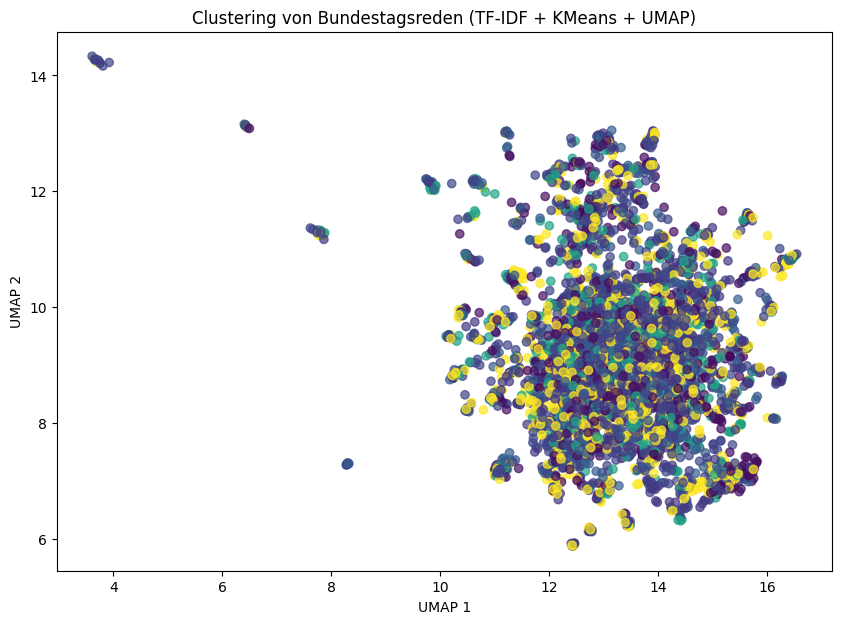

In [38]:
plt.figure(figsize=(10,7))
plt.scatter(coords[:,0], coords[:,1], c=subspeeches["faction_id"], alpha=0.7)
plt.title("Clustering von Bundestagsreden (TF-IDF + KMeans + UMAP)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

In [20]:
def preprocess(text):
    # alles lowercase, nur alphabetische Wörter
    tokens = re.findall(r'\b[a-zäöüß]+\b', text)
    return tokens

# optional: einfache Stopword-Liste (kann angepasst werden)
# stopwords = set(["und", "oder", "aber", "die", "der", "das", "wir", "ihr", "sie", "ist", "im", "für", "zu"])


def speeches_to_counts(df):
    all_counts = []
    for party, group in df.groupby("faction_name"):
        tokens = []
        for text in group["speech_content"]:
            tokens.extend([t for t in preprocess(text)])
        counts = Counter(tokens)
        party_df = pd.DataFrame({
            "party": party,
            "word": list(counts.keys()),
            "count": list(counts.values())
        })
        all_counts.append(party_df)
    return pd.concat(all_counts, ignore_index=True)


In [21]:
df = speeches_to_counts(speeches[(speeches["electoral_term"] == 19) & (speeches["position_short"] == "Member of Parliament")])

In [22]:
word_totals = df.groupby('word')['count'].sum()

# 2. Wörter auswählen, die mehr als 5-mal vorkommen
frequent_words = word_totals[word_totals > 0].index

# 3. DataFrame filtern
df = df[df['word'].isin(frequent_words)]




In [23]:
global_totals = df.groupby('word')['count'].sum()
party_totals = df.groupby("party")["count"].sum().rename("total")


In [24]:
df = df.merge(party_totals, on="party")


In [25]:
df["tf_party"] = df["count"] / df["total"]


In [26]:
total_all = df["count"].sum()
word_totals = df.groupby("word")["count"].sum().rename("total_word")
df = df.merge(word_totals, on="word")
df["tf_global"] = df["total_word"] / total_all


In [27]:
df["rel_tf"] = df["tf_party"] / df["tf_global"]
df["log_rel_tf"] = (np.log2(df["count"]) + 100) * df["rel_tf"]
subs = df[(df["count"] > 20) & (df["party"] != "Fraktionslos") & (df["party"] != "not found")]
subs

,party,word,count,total,tf_party,total_word,tf_global,rel_tf,log_rel_tf
0,AfD,herr,4492,1769253,0.002539,29436,0.002348,1.081258,121.244839
1,AfD,präsident,2229,1769253,0.001260,14532,0.001159,1.086808,120.768522
2,AfD,meine,5539,1769253,0.003131,31454,0.002509,1.247739,140.290061
3,AfD,damen,5524,1769253,0.003122,27027,0.002156,1.448185,162.821645
4,AfD,und,50285,1769253,0.028422,368516,0.029397,0.966831,111.782875
...,...,...,...,...,...,...,...,...,...
443381,SPD,bergkarabach,21,2496141,0.000008,126,0.000010,0.837024,87.378871
447070,SPD,impfstrategie,23,2496141,0.000009,62,0.000005,1.863053,194.732971
448169,SPD,impfdosen,27,2496141,0.000011,87,0.000007,1.558596,163.270585
449535,SPD,antigenschnelltests,22,2496141,0.000009,37,0.000003,2.986140,311.930440


In [147]:

metric = "rel_tf"
top_words = (
    subs
    .sort_values(["party", metric], ascending=[True, False])
    .groupby("party")
    .head(5)
)

# Reihenfolge: erst AfD, dann CDU, dann SPD usw. (du kannst die Liste anpassen)
# party_order = ["AfD", "CDU/CSU", "SPD", "FDP", "Grüne", "DIE LINKE."]

# top_words["party"] = pd.Categorical(top_words["party"], categories=party_order, ordered=True)

# Für die X-Achse sortieren: nach Partei und LLR
top_words = top_words.sort_values(["party", metric], ascending=[True, False])

# Kombiniere Partei + Wort für die Achse
top_words["label"] = top_words["party"].astype(str) + ": " + top_words["word"]

# --- Plotly Bar-Chart ---
fig = px.bar(
    top_words,
    y="word",
    x=metric,
    color="party",
    color_discrete_map=color_map,
    orientation="h",
    hover_data=["count","rel_tf"],

    title="Top 5 typische Wörter pro Partei (relative Frequenzy)",
)

# Layout anpassen (schöne Labels, horizontale Platzierung)
fig.update_layout(
    title="Top 5 typische Wörter pro Partei (relative Frequenz)",
    title_font=dict(size=24),   # Titel größer

    xaxis_title="relative Frequenz",
    xaxis_title_font=dict(size=20),   # X-Achsentitel
    xaxis_tickfont=dict(size=16),     # X-Achsen-Ticks

    yaxis_title="Wort",
    yaxis_title_font=dict(size=20),   # Y-Achsentitel
    yaxis_tickfont=dict(size=16),     # Y-Achsen-Ticks

    legend_title_font=dict(size=18),  # Legendentitel
    legend_font=dict(size=16),        # Legendentexte

    bargap=0.2,
    height=1200,
    width=1200,
)

fig.show()

GEdanken dazu:
bei rel_tf:
- die CDU ist immer recht niedrig unterwegs, die haben nix großen wie zB KLimaschutz
- die AfD hat tolle Wortneuschöpfungen
- parteien sprechen gern über sich sleber / erwähnen oft Namen
- bei count > 20 sieht man lustige wortneuschöpfungen der AfD, generell gute Einstellung für Wörter

log_rel_tf:
- hebt auch bei der CDU ein paar mehr Wörter hervor, nee eig nicht, bei > 20 wörtern reicht auch rel_tf

### log likelihood probieren
- hat auch nicht wirklich was gebracht

In [29]:
word_party = df.pivot_table(index='word', columns='party', values='count', fill_value=0)

In [30]:
party_totals = word_party.sum(axis=0)
N = party_totals.sum()

In [31]:
def log_likelihood(k11, n1, k21, n2):
    # Kontingenztafel
    k12 = n1 - k11
    k22 = n2 - k21


    # erwartete Werte
    E11 = n1 * (k11 + k21) / (n1 + n2)
    E12 = n1 * (k12 + k22) / (n1 + n2)
    E21 = n2 * (k11 + k21) / (n1 + n2)
    E22 = n2 * (k12 + k22) / (n1 + n2)


    # kleine Korrektur, um log(0) zu vermeiden
    def term(k, E):
        return 0 if k == 0 else k * np.log(k / E)


    G2 = 2 * (term(k11,E11) + term(k12,E12) + term(k21,E21) + term(k22,E22))
    return G2   

In [32]:
results = []
for word, row in word_party.iterrows():
    for party in word_party.columns:
        k11 = row[party] # Wort in Partei
        n1 = party_totals[party] # alle Wörter in Partei
        k21 = row.sum() - k11 # Wort in Rest
        n2 = N - n1 # alle Wörter im Rest


        llr = log_likelihood(k11, n1, k21, n2)
        results.append((word, party, llr, k11))

In [33]:
llr_df = pd.DataFrame(results, columns=["word", "party", "llr", "count"])
llr_df
subs2 = llr_df[(llr_df["count"] > 20) & (llr_df["party"] != "Fraktionslos") & (llr_df["party"] != "not found")]
subs2



,word,party,llr,count
0,a,AfD,1.723049,62.0
1,a,CDU/CSU,0.110944,153.0
2,a,DIE LINKE.,3.639532,69.0
3,a,FDP,0.410825,67.0
5,a,Grüne,1.254933,52.0
...,...,...,...,...
1597797,übrigens,Grüne,4.497500,466.0
1597798,übrigens,SPD,1.485356,898.0
1597873,übt,CDU/CSU,0.826788,21.0
1597897,übung,CDU/CSU,6.561334,38.0


In [34]:
top_words = (
    subs2
    .sort_values(["party", "llr"], ascending=[True, False])
    .groupby("party")
    .head(5)
)

top_words = top_words[(top_words["party"] != "Fraktionslos") & (top_words["party"] != "not found")]

# Reihenfolge: erst AfD, dann CDU, dann SPD usw. (du kannst die Liste anpassen)
party_order = ["AfD", "CDU/CSU", "SPD", "FDP", "Grüne", "DIE LINKE.","Fraktionslos","not found"]

top_words["party"] = pd.Categorical(top_words["party"], categories=party_order, ordered=True)

# Für die X-Achse sortieren: nach Partei und LLR
top_words = top_words.sort_values(["party", "llr"], ascending=[True, False])

# Kombiniere Partei + Wort für die Achse
top_words["label"] = top_words["party"].astype(str) + ": " + top_words["word"]

# --- Plotly Bar-Chart ---
fig = px.bar(
    top_words,
    y="label",
    x="llr",
    color="party",
    title="Top 5 typische Wörter pro Partei (Log-Likelihood)",
    orientation="h",
    color_discrete_map=color_map
)

# Layout anpassen (schöne Labels, horizontale Platzierung)
fig.update_layout(
    xaxis_title="Partei / Wort",
    yaxis_title="Log-Likelihood",
    xaxis_tickangle=45,
    bargap=0.2,
    height=1200,
    width=1200,
    
)

fig.show()


In [35]:
top_words = llr_df.sort_values(["party","llr"], ascending=[True,False]).groupby("party").head(10)
print(top_words)

                       word      party          llr    count
1515240                 wir        AfD  8526.484113  18288.0
747872          kolleginnen        AfD  3541.148442    626.0
654888                  ich        AfD  3166.349901  10305.0
269560                 dass        AfD  2046.257100  12408.0
91488                  auch        AfD  1993.767680  13700.0
...                     ...        ...          ...      ...
1001071                 pcr  not found    67.709458     11.0
245423               bürger  not found    62.262109     54.0
374447   entscheidungsmitte  not found    59.324987      5.0
213319            blacklist  not found    57.751171      6.0
747879          kolleginnen  not found    53.341481     14.0

[80 rows x 4 columns]


In [36]:
results = []
vocab = df['word'].unique()
parties = df['party'].unique()

In [37]:
party_totals = df.groupby('party')['count'].sum()
global_totals = df.groupby('word')['count'].sum()
total_count = df['count'].sum()



In [38]:
party_counts = df[df['party'] == "FDP"].set_index('word')['count'].reindex(vocab, fill_value=0)
party_counts

word
herr                  4713
präsident             2036
meine                 4597
damen                 3834
und                  43035
                     ...  
presseamt                0
örr                      0
fragmentierter           0
ermüdungssymptome        0
blütentraum              0
Name: count, Length: 199771, dtype: int64

In [39]:
alpha = 0.001
for party in parties:
    # Counts für aktuelle Partei
    party_counts = df[df['party'] == party].set_index('word')['count'].reindex(vocab, fill_value=0)
    n_i = party_totals[party]
    
    # Counts für alle anderen Parteien (Rest)
    rest_counts = global_totals - party_counts
    n_rest = total_count - n_i
    
    # Log-Odds mit Dirichlet Prior
    log_odds = np.log((party_counts + alpha) / (n_i - party_counts + alpha * (len(vocab)-1))) \
                - np.log((rest_counts + alpha) / (n_rest - rest_counts + alpha * (len(vocab)-1)))
    
    # Varianzschätzung
    var = 1.0 / (party_counts + alpha) + 1.0 / (rest_counts + alpha)
    
    # Z-Scores
    z_scores = log_odds / np.sqrt(var)
    
    tmp = pd.DataFrame({
        'party': party,
        'word': vocab,
        'log_odds': log_odds.values,
        'z_score': z_scores.values
    })
    results.append(tmp)

In [40]:
finals = pd.concat(results, ignore_index=True)
finals = finals.merge(df, on=['party', 'word'], how='left')
finals["tf"] = finals.apply(
    lambda row: row['count'] / party_totals[row['party']], axis=1
)

In [41]:
subs3 = finals[(finals["count"] > 20) & (finals["party"] != "Fraktionslos") & (finals["party"] != "not found")]
subs

,party,word,count,total,tf_party,total_word,tf_global,rel_tf,log_rel_tf
0,AfD,herr,4492,1769253,0.002539,29436,0.002348,1.081258,121.244839
1,AfD,präsident,2229,1769253,0.001260,14532,0.001159,1.086808,120.768522
2,AfD,meine,5539,1769253,0.003131,31454,0.002509,1.247739,140.290061
3,AfD,damen,5524,1769253,0.003122,27027,0.002156,1.448185,162.821645
4,AfD,und,50285,1769253,0.028422,368516,0.029397,0.966831,111.782875
...,...,...,...,...,...,...,...,...,...
443381,SPD,bergkarabach,21,2496141,0.000008,126,0.000010,0.837024,87.378871
447070,SPD,impfstrategie,23,2496141,0.000009,62,0.000005,1.863053,194.732971
448169,SPD,impfdosen,27,2496141,0.000011,87,0.000007,1.558596,163.270585
449535,SPD,antigenschnelltests,22,2496141,0.000009,37,0.000003,2.986140,311.930440


In [145]:
metric = "z_score"
top_words = (
    subs3
    .sort_values(["party", metric], ascending=[True, False])
    .groupby("party")
    .head(5)
)

# Reihenfolge: erst AfD, dann CDU, dann SPD usw. (du kannst die Liste anpassen)
# party_order = ["AfD", "CDU/CSU", "SPD", "FDP", "Grüne", "DIE LINKE."]

# top_words["party"] = pd.Categorical(top_words["party"], categories=party_order, ordered=True)

# Für die X-Achse sortieren: nach Partei und LLR
top_words = top_words.sort_values(["party", metric], ascending=[True, False])

# Kombiniere Partei + Wort für die Achse
top_words["label"] = top_words["party"].astype(str) + ": " + top_words["word"]

# --- Plotly Bar-Chart ---
fig = px.bar(
    top_words,
    y="label",
    x=metric,
    color="party",
    color_discrete_map=color_map,
    orientation="h",
    hover_data=["count","rel_tf"],

    title="Top 5 typische Wörter pro Partei (z-score)",
)

# Layout anpassen (schöne Labels, horizontale Platzierung)
fig.update_layout(
    xaxis_title="Partei / Wort",
    yaxis_title="z-score",
    xaxis_tickangle=45,
    bargap=0.2,
    height=1200,
    width=1200,
)

fig.show()

In [43]:
df[df["word"] == "marktwirtschaftliche"]

,party,word,count,total,tf_party,total_word,tf_global,rel_tf,log_rel_tf
40491,AfD,marktwirtschaftliche,5,1769253,0.000003,80,0.000006,0.442842,45.312398
94566,CDU/CSU,marktwirtschaftliche,31,3838391,0.000008,80,0.000006,1.265554,132.825224
234896,DIE LINKE.,marktwirtschaftliche,2,1353155,0.000001,80,0.000006,0.231606,23.392255
249055,FDP,marktwirtschaftliche,34,1526179,0.000022,80,0.000006,3.490935,366.853460
315136,Fraktionslos,marktwirtschaftliche,1,47980,0.000021,80,0.000006,3.265939,326.593867
331275,Grüne,marktwirtschaftliche,3,1471634,0.000002,80,0.000006,0.319440,32.450331
414900,SPD,marktwirtschaftliche,4,2496141,0.000002,80,0.000006,0.251107,25.612933


In [44]:
finals.sort_values('z_score', ascending=False).groupby('party').head(10)

,party,word,log_odds,z_score,count,total,tf_party,total_word,tf_global,rel_tf,log_rel_tf,tf
389176,CDU/CSU,ginsep,0.359681,84.017421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
503010,DIE LINKE.,regulierungsmaßnahmen,2.510448,77.360284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
634359,FDP,versorgungsbedarf,3.316828,59.274868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1148555,Grüne,konkurrentennachteil,0.367162,54.096108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1388031,SPD,ginsep,0.258829,53.247673,1.0,2496141.0,4.006184e-07,1.0,7.977040e-08,5.022144,502.214378,4.006184e-07
...,...,...,...,...,...,...,...,...,...,...,...,...
825821,Fraktionslos,propagierte,3.451038,9.776190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1463039,not found,lärmschutzwänden,1.081415,9.694691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1497033,not found,umfragetief,4.250129,9.554159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1429074,not found,kuschelkurs,1.303653,9.533157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
cont_ext.groupby("type").size().reset_index(name="anzahl")

,type,anzahl
0,Beifall,1471300
1,Heiterkeit,19967
2,Lachen,28872
3,Personen-Einruf,733093
4,Unruhe,367
5,Widerspruch,18975
6,Zuruf,223604
7,Zustimmung,50034


In [46]:
cont_ext2 = cont_ext.merge(speeches[["faction_name","id","electoral_term"]], right_on="id",left_on="speech_id")
cont_ext2 = cont_ext2.drop(cont_ext2[(cont_ext2["faction_name_x"] == "DP") & (cont_ext2["electoral_term"] > 3)].index)
# bei electoral Term 10 ist die DP vertreten, dies ist ein einlesefehler, weil damit eig die FDP gemeint ist.
# die DP existiert da garnicht mehr

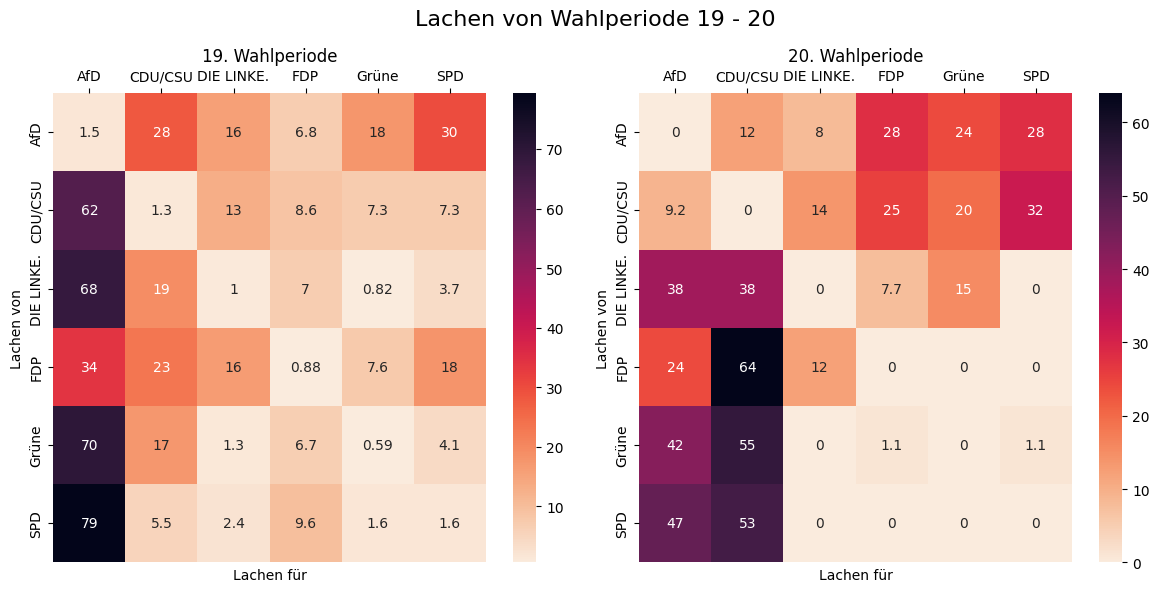

In [144]:
import matplotlib.pyplot as plt
start = 19
length = 2
normalisiert = True

TYP = "Lachen"
fig, axes = plt.subplots(1,length, figsize=(6 * length, 6))  # 1 Zeile, 2 Spalten
fig.suptitle(f"{TYP} von Wahlperiode {start} - {start+length - 1}", fontsize=16)
beifall = cont_ext2[(cont_ext2["type"] == TYP) & 
                    (cont_ext2["faction_name_x"] != "not found") & 
                    (cont_ext2["faction_name_y"] != "not found") & 
                    (cont_ext2["faction_name_x"] != "Gast") &
                    (cont_ext2["faction_name_y"] != "Gast") & 
                    (cont_ext2["faction_name_x"] != "Fraktionslos") & 
                    (cont_ext2["faction_name_y"] != "Fraktionslos")]

grouped = beifall.groupby(["faction_name_x" , "faction_name_y","electoral_term"]).size().reset_index(name="beifälle")
for WAHLPERIODE in range(start, start + length):
    gegenseitig = grouped[grouped["electoral_term"] == WAHLPERIODE].pivot_table(index = "faction_name_x" ,columns= "faction_name_y" ,values="beifälle",aggfunc="sum",fill_value=0)


    # quadratische Matrix sicherstellen
    all_factions = sorted(set(gegenseitig.index) | set(gegenseitig.columns))
    gegenseitig = gegenseitig.reindex(index=all_factions, columns=all_factions, fill_value=0)

    # normalisieruen wieviel prozent der Beifälle einer Partei an andere Parteien gehen
    genormt_zeile = gegenseitig.div(gegenseitig.sum(axis=1),axis=0) * 100

    sns.heatmap(genormt_zeile if normalisiert else gegenseitig , ax=axes[WAHLPERIODE - start], annot=True,cmap="rocket_r")
    axes[WAHLPERIODE - start].set(xlabel = f"{TYP} für" , ylabel = f"{TYP} von",title = f"{WAHLPERIODE}. Wahlperiode")
    axes[WAHLPERIODE - start].xaxis.tick_top()
plt.tight_layout()
plt.show()

In [ ]:
# fig.savefig("../Bilder/4bis10_beifall")

## Gedanken dazu:
- man sieht gut die KOlaitionen von wahlperiode 4 bis 9 bei Beifall
- erst FDP mit CDU, bei 5 dann haupsächlich SPD CDU und später dann FDP und SPD
- 

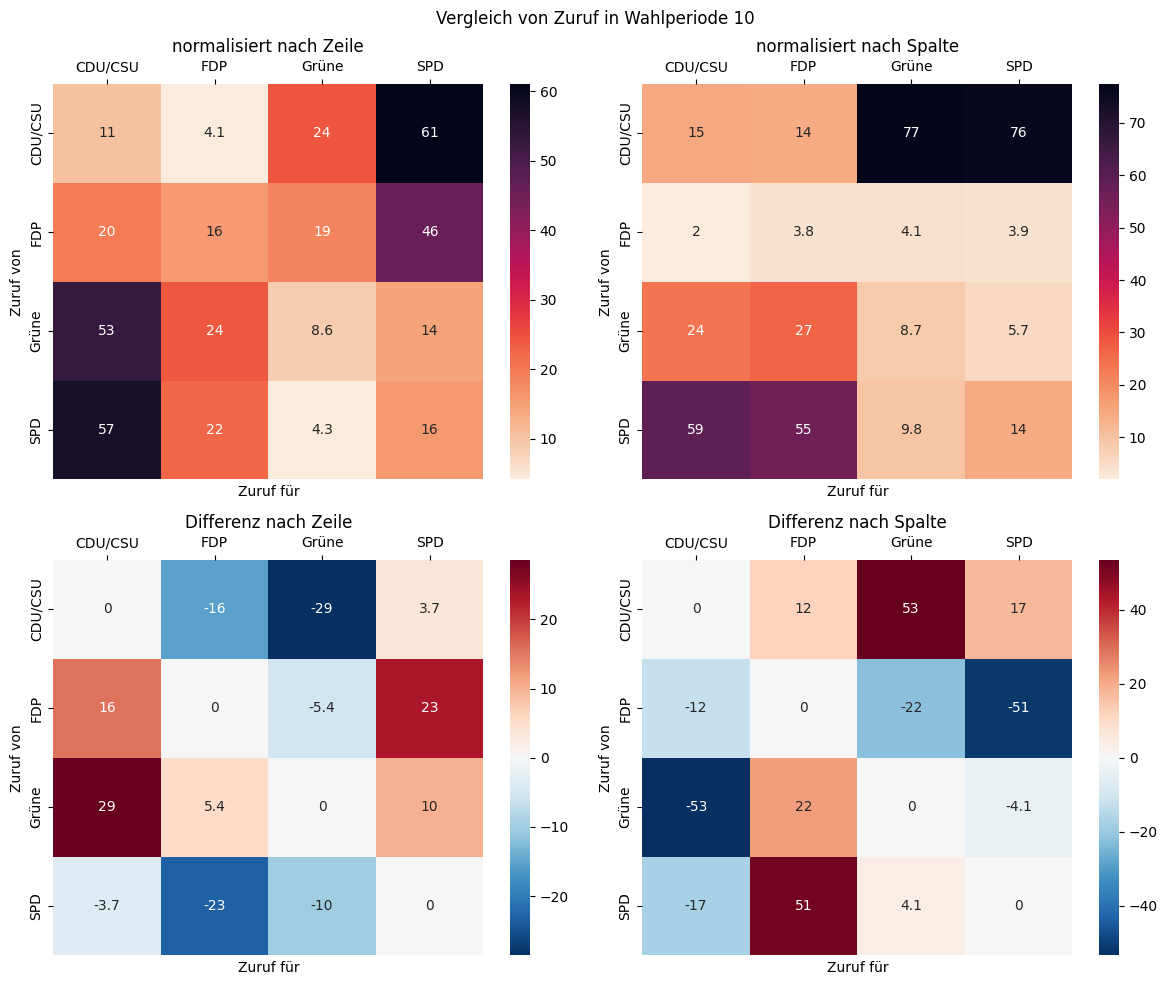

In [48]:
import matplotlib.pyplot as plt
'''
Typen: 

Beifall
Heiterkeit
Lachen
Personen-Einruf
Unruhe
Widerspruch
Zuruf
Zustimmung
'''
WAHLPERIODE = 10
TYP = "Zuruf"
normalisiert = True

# nur Beifall raussortieren
beifall = cont_ext2[(cont_ext2["type"] == TYP) & 
                    (cont_ext2["faction_name_x"] != "not found") & 
                    (cont_ext2["faction_name_y"] != "not found") & 
                    (cont_ext2["faction_name_x"] != "Gast") &
                    (cont_ext2["faction_name_y"] != "Gast") & 
                    (cont_ext2["faction_name_x"] != "Fraktionslos") & 
                    (cont_ext2["faction_name_y"] != "Fraktionslos")]
# beifall = cont_ext2[(cont_ext2["type"] == "Beifall") & (cont_ext2["faction_name_x"].isin(big_party))& (cont_ext2["faction_name_y"].isin(big_party))]

# nach partei zählen
grouped = beifall.groupby(["faction_name_x" , "faction_name_y","electoral_term"]).size().reset_index(name="beifälle")

# ne matrix drauß machen
gegenseitig = grouped[grouped["electoral_term"] == WAHLPERIODE].pivot_table(index = "faction_name_x" ,columns= "faction_name_y" ,values="beifälle",aggfunc="sum",fill_value=0)


# quadratische Matrix sicherstellen
all_factions = sorted(set(gegenseitig.index) | set(gegenseitig.columns))
gegenseitig = gegenseitig.reindex(index=all_factions, columns=all_factions, fill_value=0)

# normalisieruen wieviel prozent der Beifälle einer Partei an andere Parteien gehen
genormt_zeile = gegenseitig.div(gegenseitig.sum(axis=1),axis=0) * 100
genormt_spalte = gegenseitig.div(gegenseitig.sum(axis=0),axis=1) * 100

fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 1 Zeile, 2 Spalten
fig.suptitle(f"Vergleich von {TYP} in Wahlperiode {WAHLPERIODE}")

sns.heatmap(genormt_zeile if normalisiert else gegenseitig , ax=axes[0][0], annot=True,cmap="rocket_r")
axes[0][0].set(xlabel = f"{TYP} für" , ylabel = f"{TYP} von",title = "normalisiert nach Zeile")
axes[0][0].xaxis.tick_top()


sns.heatmap(genormt_spalte if normalisiert else gegenseitig , ax=axes[0][1], annot=True,cmap="rocket_r")
axes[0][1].set(xlabel = f"{TYP} für" , ylabel = f"{TYP} von",title = "normalisiert nach Spalte")
axes[0][1].xaxis.tick_top()

differenz_zeile = genormt_zeile - genormt_zeile.T
differenz_spalte = genormt_spalte - genormt_spalte.T

sns.heatmap(differenz_zeile,ax=axes[1][0], annot=True,cmap="RdBu_r")
axes[1][0].set(xlabel = f"{TYP} für" , ylabel = f"{TYP} von" , title = "Differenz nach Zeile")
axes[1][0].xaxis.tick_top()

sns.heatmap(differenz_spalte,ax=axes[1][1], annot=True,cmap="RdBu_r")
axes[1][1].set(xlabel = f"{TYP} für" , ylabel = f"{TYP} von", title = "Differenz nach Spalte" )
axes[1][1].xaxis.tick_top()

plt.tight_layout()
plt.show()

### Gedanken dazu:

- man kann supi sehen, wer in welcher Wahlperiode gemeinsam regiert hat
- Beispielhaft vorallem die frühen Perioden 3- 9

- wenn man sich die differenzen anguckt, kann man auch gut sehen, dass niemand wirklich für die AfD applaudiert

- ganz schön viel Widerspruch aus allen Reihen an die AfD
- auch wird viel über die AfD gelacht

- links ist nach Zeile normalisiert, also man sieht zu welcher Partei am meisten Zugerufen wurde
- rechts ist nach SPalte normalisiert, da sieht man von welcher Partei die meisten Zurufe an die eigene Partei kamen


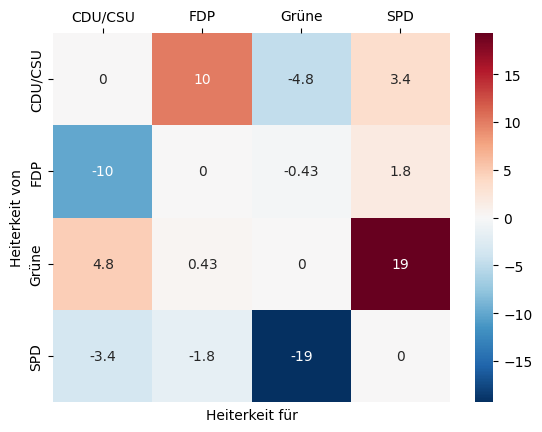

In [ ]:
# unterschied wie oft p1 für p2 klatscht, aber p2 für p1 nicht applaudiert
differenz = genormt_zeile - genormt_zeile.T

ax = sns.heatmap(differenz,annot=True,cmap="RdBu_r")
ax.set(xlabel = f"{TYP} für" , ylabel = f"{TYP} von")
ax.xaxis.tick_top()

In [49]:
grouped_all = cont_ext2.groupby(["electoral_term","type"]).size().reset_index(name="anzahl")
grouped_all

,electoral_term,type,anzahl
0,1,Beifall,16361
1,1,Heiterkeit,643
2,1,Lachen,1879
3,1,Personen-Einruf,20713
4,1,Unruhe,126
...,...,...,...
151,20,Lachen,417
152,20,Personen-Einruf,8924
153,20,Widerspruch,267
154,20,Zuruf,2220


In [50]:
fig = px.line(grouped_all,x="electoral_term" , y="anzahl", color="type")
einzug_wahlperioden = {
    "Grüne": 10,
    "DIE LINKE.": 16,
    "AfD": 19
}

farben_linie = {
    "Grüne": "#6AB023",
    "DIE LINKE.": "#BE3075",
    "AfD": "#009EE0"
}

for partei, wahlperiode in einzug_wahlperioden.items():
    fig.add_vline(
        x=wahlperiode,
        line_width=2,
        line_dash="dash",
        line_color=farben_linie[partei],
        annotation_text=f"Einzug {partei}",
        annotation_position="top right",
        annotation_font_color=farben_linie[partei]
    )
fig.show()

In [126]:
import plotly.graph_objects as go

fig = go.Figure()

# Jede Zwischenruf-Art separat normieren und hinzufügen
for typ, df_typ in grouped_all.groupby("type"):
    rel_anzahl = df_typ["anzahl"] / df_typ["anzahl"].max()  # Normierung pro Typ
    
    fig.add_trace(
        go.Scatter(
            x=df_typ["electoral_term"],
            y=rel_anzahl,
            mode="lines+markers",
            name=typ
        )
    )

# Vertikale Linien für Parteieinzüge
einzug_wahlperioden = {
    "Grüne": 10,
    "DIE LINKE.": 16,
    "AfD": 19
}

farben_linie = {
    "Grüne": "#6AB023",
    "DIE LINKE.": "#BE3075",
    "AfD": "#009EE0"
}

for partei, wahlperiode in einzug_wahlperioden.items():
    fig.add_vline(
        x=wahlperiode,
        line_width=2,
        line_dash="dash",
        line_color=farben_linie[partei],
        annotation_text=f"Einzug {partei}",
        annotation_position="top right",
        annotation_font_color=farben_linie[partei]
    )

# Layout
fig.update_layout(
    title="Relative Entwicklung der Zwischenruf-Typen",
    xaxis_title="Wahlperiode",
    yaxis_title="Relativer Verlauf (pro Typ normiert)",
    legend_title="Typ",
    template="plotly_white"
)

fig.show()


### Gedanken dazu:
- Unruhe nimmt stark ab in den ersten Perioden, wahrsceinlich weil Nazis und KPD so langsam rausfliegen
- actually mal den typ nach Partei aufteilen
- jede art von zwischenruf ist beim Einzug der Grünen angestiegen
- 

In [52]:
grouped_faction = cont_ext2.groupby(["electoral_term","type","faction_name_x"]).size().reset_index(name="anzahl")

In [130]:
typ = "Lachen"
fig = px.bar(grouped_faction[grouped_faction["type"] == typ], 
       x="electoral_term",
       y="anzahl",
       color="faction_name_x",
       color_discrete_map=color_map,
       )
einzug_wahlperioden = {
    "Grüne": 10 -0.5,
    "DIE LINKE.": 16 - 0.5,
    "AfD": 19 - 0.5
}

farben_linie = {
    "Grüne": "#6AB023",
    "DIE LINKE.": "#BE3075",
    "AfD": "#009EE0"
}

for partei, wahlperiode in einzug_wahlperioden.items():
    fig.add_vline(
        x=wahlperiode,
        line_width=2,
        line_dash="dash",
        line_color=farben_linie[partei],
        annotation_text=f"Einzug {partei}",
        annotation_position="top right",
        annotation_font_color=farben_linie[partei]
    )

fig.update_layout(showlegend=False,title=f"{typ} über die Jahre")

### Gedanken:
- joa, hier sieht man iwi nicht so viel
- generelle Unruhe lässt sich nicht auf einzelne Fraktionen Zuordnen, diese ist eher immer aus einer generellen Richtung gekommen

In [ ]:
beifall[beifall["faction_name_x"] == beifall["faction_name_y"]]

,id_x,type,first_name,last_name,politician_id,content,speech_id,text_position,faction_id,faction_name_x,faction_name_y,id_y,electoral_term
8,8,Heiterkeit,,,-1,,13,3,23,SPD,SPD,13,1
211,211,Heiterkeit,,,-1,,61,30,23,SPD,SPD,61,1
223,223,Heiterkeit,,,-1,,61,17,23,SPD,SPD,61,1
1287,1287,Heiterkeit,,,-1,,252,51,23,SPD,SPD,252,1
1412,1412,Heiterkeit,,,-1,,318,4,25,WAV,WAV,318,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2543724,2543724,Heiterkeit,,,-1,,1072366,10,4,CDU/CSU,CDU/CSU,1072366,20
2544007,2544007,Heiterkeit,,,-1,,1072416,7,4,CDU/CSU,CDU/CSU,1072416,20
2544388,2544388,Heiterkeit,,,-1,,1072502,0,4,CDU/CSU,CDU/CSU,1072502,20
2545377,2545377,Heiterkeit,,,-1,,1072700,5,23,SPD,SPD,1072700,20


In [ ]:
speeches[speeches["id"] == 298566]

,id,session,electoral_term,politician_id,speech_content,faction_id,document_url,position_short,position_long,date,speech_length,faction_name
298596,298566,139,8,11001022,herr präsident! meine sehr geehrten damen und ...,23,https://dip21.bundestag.de/dip21/btp/08/08139.pdf,Member of Parliament,NA,1979-02-16,4847,SPD


In [ ]:
speeches[["faction_id","id"]]

,faction_id,id
0,-1,0
1,-1,1
2,-1,2
3,-1,3
4,-1,4
...,...,...
919518,23,1072832
919519,-1,1072833
919520,4,1072834
919521,-1,1072835


In [56]:
speechs_per_factions = speeches[speeches["position_short"] == "Member of Parliament"].groupby(["electoral_term" , "faction_name"])["speech_length"].sum().reset_index()
speechs_per_factions

,electoral_term,faction_name,speech_length
0,1,BP,1200948
1,1,CDU/CSU,8861600
2,1,DP,2714547
3,1,DRP,81548
4,1,FDP,5079844
...,...,...,...
115,20,DIE LINKE.,912238
116,20,FDP,1521992
117,20,Grüne,1744094
118,20,SPD,2969608


In [58]:
fig = px.bar(
    speechs_per_factions,
    x="electoral_term",
    y="speech_length",
    color="faction_name",
    color_discrete_map=color_map,
    labels={"electoral_term": "Wahlperiode", 
            "speech_length": "Länge der Reden", 
            "faction_name": "Fraktion", 
            "speeches" : "Reden"},
    title="Redelänge von MdB aufgeteilt nach Fraktion",
)
einzug_wahlperioden = {
    "Grüne": 10 -0.5,
    "DIE LINKE.": 16 - 0.5,
    "AfD": 19 - 0.5
}

farben_linie = {
    "Grüne": "#6AB023",
    "DIE LINKE.": "#BE3075",
    "AfD": "#009EE0"
}

for partei, wahlperiode in einzug_wahlperioden.items():
    fig.add_vline(
        x=wahlperiode,
        line_width=2,
        line_dash="dash",
        line_color=farben_linie[partei],
        annotation_text=f"Einzug {partei}",
        annotation_position="top right",
        annotation_font_color=farben_linie[partei]
    )

fig.update_layout(showlegend=False)
fig.show()

### interpretation

- relativ ausgeglichen viel geredet
- ein trend zu mehr geyappe
- von 40M Buchstaben zu 100M in recent years


In [67]:
cont_sim.tail(10)

,id,text_position,speech_id,content
2190683,936063,6,499517,(Jochen Borchert [CDU/CSU]: Das habe ich auch ...
2190684,936064,5,499517,(Jochen Borchert [CDU/CSU]: Ja!)
2190685,936065,4,499517,"(Beifall bei der SPD, der PDS/Linke Liste sowi..."
2190686,936066,3,499517,(Dr. Nils Diederich [Berlin] [SPD]: Natürlich ...
2190687,936067,2,499517,(Zuruf von der SPD: Hört! Hört!)
2190688,936068,1,499517,(Heiterkeit und Beifall bei der SPD und der CD...
2190689,936069,0,499517,(Beifall bei der SPD und der PDS/Linke Liste -...
2190690,936070,0,499518,(Eduard Oswald [CDU/CSU]: Der Herr Staatssekre...
2190691,936071,4,499519,(Beifall bei der SPD und der PDS/Linke Liste)
2190692,936072,3,499519,(Beifall der Abg. Uta Würfel [F.D.P.])


In [59]:
df_merged = cont_ext.merge(speeches[['id', 'date','electoral_term']], left_on='speech_id', right_on='id', how='left')

In [60]:
präse_reden = speeches[speeches["position_short"] == "Presidium of Parliament"]

In [61]:
rügen_pattern = r" rüge"
rügen = speeches[speeches["speech_content"].str.contains(
    rügen_pattern,
    regex=True    # Regulären Ausdruck verwenden
)]


In [62]:
pattern = r"ordnungsruf|zur ordnung|ich rufe[^.?!]*zur ordnung"
orufe = speeches[speeches["speech_content"].str.contains(
    pattern,
    regex=True    # Regulären Ausdruck verwenden
)]

In [63]:
pattern2 = r"ordnungsruf|ich rufe[^.?!]*zur ordnung"
orufe2 = speeches[speeches["speech_content"].str.contains(
    pattern2,
    regex=True    # Regulären Ausdruck verwenden
)]

In [64]:
redezeit_pattern = r"redezeit"
redezeit = speeches[speeches["speech_content"].str.contains(
    redezeit_pattern,
    regex=True    # Regulären Ausdruck verwenden
)]

In [115]:
# in langen Reden kann es vorkommen, dass gebittet wird, und das wort "schluss" viel später vorkommnt, also garkeinen Bezug auf die redezeit hat
max_dist = 50
# der Term: \b[ .,!?:;]? 
# sorgt dafür, dass würter wie: "schluss" definitiv aufhören, also dass "schlussfolgerung" nicht gezählt wird als Wort

orufe_pattern_viel = (
    rf"ich rufe.{{0,{max_dist}}}\bzur ordnung"
    rf"|ich rüge.{{0,{max_dist}}} sie"
    rf"|rüge ich sie"
    rf"|ich bitte.{{0,{max_dist}}}um ruhe"
    rf"|ordnungsruf"
    rf"|ich rufe.{{0,{max_dist}}}zur ordnung"


)
orufe_viel = präse_reden[präse_reden["speech_content"].str.contains(
    orufe_pattern_viel,
    regex=True    # Regulären Ausdruck verwenden
)]

In [118]:
orufe_n = orufe_viel.groupby("electoral_term").size()

In [124]:
fig = px.bar(orufe_n,title="Ordnungsrufandrohungen pro Wahlperiode")
einzug_wahlperioden = {
    "Grüne": 10,
    "DIE LINKE.": 16,
    "AfD": 19
}

farben_linie = {
    "Grüne": "#6AB023",
    "DIE LINKE.": "#BE3075",
    "AfD": "#009EE0"
}

for partei, wahlperiode in einzug_wahlperioden.items():
    fig.add_vline(
        x=wahlperiode - 0.5,
        line_width=2,
        line_dash="dash",
        line_color=farben_linie[partei],
        annotation_text=f"Einzug {partei}",
        annotation_position="top right",
        annotation_font_color=farben_linie[partei]
    )
fig.update_layout(showlegend = False)
fig.show()

In [65]:

# in langen Reden kann es vorkommen, dass gebittet wird, und das wort "schluss" viel später vorkommnt, also garkeinen Bezug auf die redezeit hat
max_dist = 50
# der Term: \b[ .,!?:;]? 
# sorgt dafür, dass würter wie: "schluss" definitiv aufhören, also dass "schlussfolgerung" nicht gezählt wird als Wort

redezeit_pattern_viel = (
    rf"(kommen sie bitte.{{0,{max_dist}}}zum schluss\b[ .,!?:;]?"
    rf"|ich darf sie bitten.{{0,{max_dist}}}(?:zum )?\b(ende|schluss)\b[ .,!?:;]?"
    rf"|ich (muss|möchte) sie (bitten|auffordern).{{0,{max_dist}}}(?:zum )?\b(ende|schluss)\b[ .,!?:;]?"
    rf"|(die|ihre) redezeit (ist|war).{{0,{max_dist}}}\b(abgelaufen|überschritten|vorbei|zu ende|um|beendet)\b[ .,!?:;]?"
    rf"|(die|ihre) redezeit.{{0,{max_dist}}}\b(abgelaufen|überschritten|vorbei|zu ende|um|beendet).{{0,{max_dist}}}\b[ .,!?:;]? (ist|war)"
    rf"|(die|ihre) redezeit.{{0,{max_dist}}}\büberschritten"
    rf"|ich entziehe ihnen das wort\b[ .,!?:;]?"
    rf"|bitte.{{0,{max_dist}}}beenden sie.{{0,{max_dist}}}\bausführungen\b[ .,!?:;]?"
    rf"|(ich erinnere|denken sie).{{0,{max_dist}}}an die redezeit\b[ .,!?:;]?"
    rf"|(die|ihre) redezeit erinnern\b[ .,!?:;]?"
    rf"|über ihrer? redezeit\b[ .,!?:;]?)"
)
redezeit_viel = präse_reden[präse_reden["speech_content"].str.contains(
    redezeit_pattern_viel,
    regex=True    # Regulären Ausdruck verwenden
)]

/tmp/ipykernel_5152/3067899025.py:19: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



In [66]:
max_dist = 50

# der Term: \b[ .,!?:;]? 
# sorgt dafür, dass würter wie: "schluss" definitiv aufhören, also dass "schlussfolgerung" nicht gezählt wird als Wort

redezeit_pattern_viel2 = (
    rf"(kommen sie bitte.{{0,{max_dist}}}zum schluss\b[ .,!?:;]?"
    rf"|ich darf sie bitten.{{0,{max_dist}}}(?:zum )?\b(ende|schluss)\b[ .,!?:;]?"
    rf"|ich (muss|möchte) sie (bitten|auffordern).{{0,{max_dist}}}(?:zum )?\b(ende|schluss)\b[ .,!?:;]?"
    rf"|(die|ihre) redezeit (ist|war).{{0,{max_dist}}}\b(abgelaufen|überschritten|vorbei|zu ende|um)\b[ .,!?:;]?"
    rf"|(die|ihre) redezeit.{{0,{max_dist}}}\b(abgelaufen|überschritten|vorbei|zu ende|um).{{0,{max_dist}}}\b[ .,!?:;]? (ist|war)"
    rf"|ich entziehe ihnen das wort\b[ .,!?:;]?"
    rf"|bitte.{{0,{max_dist}}}beenden sie.{{0,{max_dist}}}\bausführungen\b[ .,!?:;]?"
    rf"|(ich erinnere|denken sie).{{0,{max_dist}}}an die redezeit\b[ .,!?:;]?"
    rf"|(die|ihre) redezeit erinnern\b[ .,!?:;]?"
    rf"|über ihrer? redezeit\b[ .,!?:;]?)"
)
redezeit_viel2 = präse_reden[präse_reden["speech_content"].str.contains(
    redezeit_pattern_viel2,
    regex=True    # Regulären Ausdruck verwenden
)]

/tmp/ipykernel_5152/2201039146.py:18: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



In [67]:
only_in_df1 = redezeit_viel[~redezeit_viel["id"].isin(redez+eit_viel2["id"])]

NameError: name 'redez' is not defined

In [68]:
rüge_index = redezeit_viel["id"].copy()
rüge_index -= 1
rüge_index
geruegte_reden = speeches[speeches["id"].isin(rüge_index)]

In [69]:
geruegte_reden = geruegte_reden[geruegte_reden["position_short"] == "Member of Parliament"]

In [70]:
geruegte_reden = geruegte_reden.merge(factions,left_on="faction_id" , right_on="id" , how="left")

In [71]:
only_in_df1

NameError: name 'only_in_df1' is not defined

In [72]:
langatmer = geruegte_reden.groupby("politician_id").size().reset_index(name="ueberschreitungen")
langatmer


,politician_id,ueberschreitungen
0,-1,56
1,11000001,3
2,11000005,1
3,11000012,1
4,11000013,1
...,...,...
1561,11005246,1
1562,11005255,1
1563,11005260,1
1564,11005262,1


In [ ]:

langatmer = langatmer.merge(politicans,left_on="politician_id",right_on="id")


NameError: name 'politicans' is not defined

In [ ]:
langatmer.sort_values("ueberschreitungen",ascending=False)


,politician_id,ueberschreitungen,id,first_name,last_name,birth_place,birth_country,birth_date,death_date,gender,profession,aristocracy,academic_title
0,-1,56,-1,Not found,,NA,NA,NA,NA,NA,NA,NA,NA
188,11000756,51,11000756,Gregor,Gysi,Berlin,Deutschland,1948-01-16,NA,männlich,"Rechtsanwalt, Autor, Moderator",NA,Dr.
260,11001023,44,11001023,Ulla,Jelpke,Hamburg,Deutschland,1951-06-09,NA,weiblich,Dipl.-Sozialökonomin,NA,NA
714,11002568,40,11002568,Thomas,Wüppesahl,Hamburg,Deutschland,1955-07-09,NA,männlich,Kriminalbeamter,NA,NA
234,11000921,39,11000921,Barbara,Höll,"Coswig / Anhalt, Krs. Roßlau, Bez. Halle",Deutschland,1957-12-26,NA,weiblich,Dipl.-Philosophin,NA,Dr.
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,11000058,1,11000058,Dieter,Auch,Stuttgart,Deutschland,1941-04-12,NA,männlich,"Werkzeugmacher, Geschäftsführer",NA,NA
15,11000062,1,11000062,Anneliese,Augustin,Kassel,Deutschland,1930-04-24,2021-11-03,weiblich,Apothekerin,NA,NA
16,11000063,1,11000063,Jürgen,Augustinowitz,Rüthen,Deutschland,1964-06-10,NA,männlich,Bankkaufmann,NA,NA
21,11000080,1,11000080,Egon,Bahr,Treffurt / Thüringen,Deutschland,1922-03-18,2015-08-19,männlich,"Abgeordneter, Bundesminister a. D.",NA,Prof.


In [74]:
mahnungen = geruegte_reden.groupby(["electoral_term" , "abbreviation" , "faction_id"]).size().reset_index(name="mahnungen")

In [75]:
speech_count = speeches.groupby(["electoral_term" , "faction_id"]).size().reset_index(name="speeches")
speech_count[speech_count["faction_id"] != -1]

,electoral_term,faction_id,speeches
1,1,2,400
2,1,4,2510
3,1,7,746
4,1,11,54
5,1,13,1476
...,...,...,...
130,20,3,619
131,20,4,1211
132,20,6,402
133,20,13,541


In [76]:
mahnungen = mahnungen.merge(speech_count,on=["electoral_term" , "faction_id"],how="left")

In [77]:
mahnungen["normalized_mahnungen"] = (mahnungen["mahnungen"] / mahnungen["speeches"]) 


In [78]:
fraktionen_pro_term = mahnungen.groupby("electoral_term")["faction_id"].nunique()
mahnungen["mahnungen_normalisiert_2"] = mahnungen.apply(
    lambda row: row["normalized_mahnungen"] / fraktionen_pro_term[row["electoral_term"]],
    axis=1
)


In [79]:
mahnungen

,electoral_term,abbreviation,faction_id,mahnungen,speeches,normalized_mahnungen,mahnungen_normalisiert_2
0,1,BP,2,15,400,0.037500,0.003125
1,1,CDU/CSU,4,13,2510,0.005179,0.000432
2,1,DP,7,10,746,0.013405,0.001117
3,1,DRP,11,3,54,0.055556,0.004630
4,1,FDP,13,21,1476,0.014228,0.001186
...,...,...,...,...,...,...,...
87,20,DIE LINKE.,6,17,402,0.042289,0.006041
88,20,FDP,13,22,541,0.040665,0.005809
89,20,Grüne,3,19,619,0.030695,0.004385
90,20,SPD,23,30,910,0.032967,0.004710


In [125]:
normalized = True


# Dein Barplot
fig = px.bar(
    mahnungen,
    x="electoral_term",
    y="mahnungen_normalisiert_2" if normalized else "mahnungen",
    color="abbreviation",
    color_discrete_map=color_map,
    labels={"electoral_term": "Wahlperiode", 
            "mahnungen": "Anzahl Mahnungen", 
            "abbreviation": "Fraktion", 
            "speeches" : "Reden"},
    title="Mahnungen pro Wahlperiode und Fraktion" if not normalized else "Mahnungen pro Wahlperiode und Fraktion normalisiert nach Rede",
        hover_data={
        "electoral_term": False,     # ← nicht anzeigen
        "speeches": True,
        "mahnungen": True,
        "mahnungen_normalisiert_2": ':.2f' if normalized else False
    }
)

# Linien für erstmaligen Einzug hinzufügen
einzug_wahlperioden = {
    "Grüne": 10,
    "DIE LINKE.": 16,
    "AfD": 19
}

farben_linie = {
    "Grüne": "#6AB023",
    "DIE LINKE.": "#BE3075",
    "AfD": "#009EE0"
}

for partei, wahlperiode in einzug_wahlperioden.items():
    fig.add_vline(
        x=wahlperiode - 0.5,
        line_width=2,
        line_dash="dash",
        line_color=farben_linie[partei],
        annotation_text=f"Einzug {partei}",
        annotation_position="top right",
        annotation_font_color=farben_linie[partei]
    )

fig.update_layout(showlegend=False)
fig.show()


# Gedanken dazu:

- wow, die KPD hat aber ordentlich die Geschäftsordnung missachtet
- ab wahlperiode 10 gings ganz schön ab mit Zeitüberschreitungen
- PDS war schein bei Wahlperiode 11 dabei, da 1990 in den Bundestag auch Parteien aus dem Osten dazukamen
- krasser anstieg ab den Grünen (10)
- krasser Anstieg ab Einzug AfD (19)
- nach einbruch von überschreitungen von 16 - 18
- keine Redeüberschreitung nach 1953?
- äh, die normalisierung ist falsch, ich darf das nicht einfach nur aufaddiere, ich muss das für jeden term noch durch die anzahl der fraktionen im parlament teilen


In [82]:
normalizer = speeches.groupby(["electoral_term"]).size().reset_index(name="speeches")

def display_pattern(pattern):
    sentences = speeches[speeches["speech_content"].str.contains(
        pattern,
        regex=True    # Regulären Ausdruck verwenden
    )]
    result = sentences.groupby("electoral_term").size().reset_index(name="orufe_count")
    result["norm_rufe"] = (result["orufe_count"] / normalizer["speeches"]) * normalizer["speeches"].mean()
    return px.bar(result,x="electoral_term",y="orufe_count",title=pattern)

def df_by_term(df, pattern):
    result = df.groupby("electoral_term").size().reset_index(name="orufe_count")
    result["norm_rufe"] = (result["orufe_count"] / normalizer["speeches"]) * normalizer["speeches"].mean()
    return px.bar(result,x="electoral_term",y="orufe_count",title=pattern) 

In [83]:
result = orufe.groupby(["electoral_term","position_short"]).size().reset_index(name="orufe_count")
px.bar(result,x="electoral_term",y="orufe_count",color="position_short")

In [ ]:
oruf_pattern = r"ordnungsruf|ich rufe[^.?!]*zur ordnung"
mahnung_pattern = r"ich mahne"
df_by_term(redezeit_viel,redezeit_pattern_viel)

In [87]:
display_pattern(orufe_pattern_viel)

In [ ]:
orufe

,id,session,electoral_term,politician_id,speech_content,faction_id,document_url,position_short,position_long,date,speech_length,faction_name
53,53,5,1,11001150,"wen meinen sie damit, herr abgeordneter renner...",-1,https://dip21.bundestag.de/dip21/btp/01/01005.pdf,Presidium of Parliament,präsident,1949-09-20,243,not found
115,111,7,1,11001150,"herr abgeordneter reimann, ich habe seit geste...",-1,https://dip21.bundestag.de/dip21/btp/01/01007.pdf,Presidium of Parliament,präsident,1949-09-22,1654,not found
121,116,7,1,11000009,meine damen und herren! der herr abgeordnete r...,-1,https://dip21.bundestag.de/dip21/btp/01/01007.pdf,Chancellor,NA,1949-09-22,705,not found
178,169,7,1,11000498,meine damen und herren! ursprünglich bestand b...,2,https://dip21.bundestag.de/dip21/btp/01/01007.pdf,Member of Parliament,NA,1949-09-22,13012,BP
383,359,11,1,11001150,"ich habe ferner darauf hinzuweisen, daß die be...",-1,https://dip21.bundestag.de/dip21/btp/01/01011.pdf,Presidium of Parliament,präsident,1949-09-30,1809,not found
...,...,...,...,...,...,...,...,...,...,...,...,...
914457,1067769,20,20,11003132,"\n\nherr kuhle, sorry. ich muss das leider dur...",-1,https://dip21.bundestag.de/dip21/btp/20/20020.pdf,Presidium of Parliament,Vizepräsidentin,2022-03-16,232,not found
914670,1067977,21,20,11003132,\n\nentschuldigung! – frau von storch?\n\n({0}...,-1,https://dip21.bundestag.de/dip21/btp/20/20021.pdf,Presidium of Parliament,Vizepräsidentin,2022-03-17,289,not found
915187,1068498,22,20,11003132,"\n\nfrau von storch, sie rufe ich jetzt zur or...",-1,https://dip21.bundestag.de/dip21/btp/20/20022.pdf,Presidium of Parliament,Vizepräsidentin,2022-03-18,504,not found
917253,1070564,31,20,11004905,\n\nich habe kein foto aus der sitzung veröffe...,0,https://dip21.bundestag.de/dip21/btp/20/20031.pdf,Member of Parliament,NA,2022-04-28,274,AfD


In [109]:
from collections import Counter

# Beispiel: DataFrame mit Spalte 'speech'
# df = pd.DataFrame({'speech': ["...ihre Redezeit beträgt zwei Minuten...", "...ihre Redezeit ist abgelaufen..."]})

# Counter für die Phrasen
phrase_counter = Counter()

# Regex-Pattern: finde 'ihre Redezeit' und hole die nächsten 2 Wörter (inkl. evtl. Bindestrich oder Punkt)
pattern = re.compile(r'zur ordnung(?:\s+\w+){1,4}')

# Durchlaufe alle Reden
for text in präse_reden["speech_content"]:
    matches = pattern.findall(text)
    for match in matches:
        # Extrahiere die zwei Wörter nach 'ihre Redezeit'
        following_words = re.sub(r'zur ordnung\s*', '', match, flags=re.IGNORECASE).strip()
        phrase_counter[following_words] += 1

# Zeige die häufigsten Kombinationen
print(phrase_counter.most_common(20))


[('rufen', 59), ('und mache sie auf', 11), ('gerufen', 8), ('zu rufen', 8), ('des wasserhaushalts', 8), ('des schornsteinfegerwesens', 4), ('und mache sie darauf', 2), ('und entziehe ihnen das', 2), ('des hebammenwesens', 2), ('des hebammenwesens notwendigen gesetze', 2), ('des handwerks', 2), ('des ingenieurberufes', 2), ('des obst', 2), ('und weise sie darauf', 2), ('für die beleidigung des', 1), ('wegen einer beleidigung der', 1), ('und ersuche sie', 1), ('führt', 1), ('des deutschen siedlungswesens vom', 1), ('das wort entzogen wird', 1)]


In [112]:
import re

# Muster für bekannte Abkürzungen, die nicht als Satzende zählen sollen
abbreviations = [
    "dr.", "prof.", "hr.", "fr.", "dipl.", "ing.", "z.b.", "u.a.", "etc.", 
    "bzw.", "d.h.", "u.v.m.", "i.d.r.", "i.s.v.", "vgl."
]
# Suchmuster für Ordnungsrufe
ordnungsruf_pattern = r"ordnungsruf|zur ordnung|ich rufe[^.?!]*zur ordnung"

for i, speech in only_in_df1.iterrows():
    if speech["position_short"] != "Presidium of Parliament":
        continue

    print(f"Rede Nummer: {speech['id']} from {speech['position_short']}")
    print(speech["date"])
    print(speech["document_url"])

    satz = speech["speech_content"]
    raw_sentences = re.split(r'(?<=[.?!])\s+', satz)

    # Dann Sätze mit Abkürzungen am Ende wieder zusammenfügen
    sentences = []
    buffer = ""
    for s in raw_sentences:
        if any(s.startswith(abbr) or buffer.endswith(abbr) for abbr in abbreviations):
            buffer += " " + s
        else:
            if buffer:
                sentences.append(buffer.strip())
            buffer = s
    if buffer:
        sentences.append(buffer.strip())

    # Sätze mit Ordnungsruf-Muster finden
    matched_sentences = [
        s for s in sentences
        if re.search(redezeit_pattern_viel, s, flags=re.IGNORECASE)
    ]

    for s in matched_sentences:
        print(s)
    # print(satz)
    print("------------------------------------------------------")


Rede Nummer: 168 from Presidium of Parliament
1949-09-22
https://dip21.bundestag.de/dip21/btp/01/01007.pdf
die frau abgeordnete kalinke hat ihre redezeit um fast hundert prozent überschritten.
------------------------------------------------------
Rede Nummer: 1667 from Presidium of Parliament
1950-01-18
https://dip21.bundestag.de/dip21/btp/01/01027.pdf
bitte, bringen sie mich nicht in die verlegenheit, ihnen in aller form das wort zu entziehen, weil sie nach der geschäftsordnung bereits die redezeit von fünf minuten um zwei minuten überschritten haben.
------------------------------------------------------
Rede Nummer: 2106 from Presidium of Parliament
1950-02-01
https://dip21.bundestag.de/dip21/btp/01/01033.pdf
herr abgeordneter, sie haben ihre redezeit schon um das doppelte überschritten.
------------------------------------------------------
Rede Nummer: 2389 from Presidium of Parliament
1950-02-09
https://dip21.bundestag.de/dip21/btp/01/01036.pdf
sie haben ihre redezeit überschrit

In [ ]:
'''
redezeit ist vorbei|abgelaufen überschritten
über ihrer redezeit
ihre redezeit ist zu ende
die redezeit war zu ende
redezeit war abgelaufen
dass ihre redezeit um ist
dass sie die redezeit deutlich überschritten haben
kommen Sie bitte zum Schluss
denken Sie bitte an die Redezeit
Kommen Sie bitte zum Schluss

'''

'\nredezeit ist vorbei|abgelaufen überschritten\nüber ihrer redezeit\nihre redezeit ist zu ende\ndie redezeit war zu ende\nredezeit war abgelaufen\ndass ihre redezeit um ist\ndass sie die redezeit deutlich überschritten haben\nkommen Sie bitte zum Schluss\ndenken Sie bitte an die Redezeit\nKommen Sie bitte zum Schluss\n\n'

In [ ]:
präse_reden[präse_reden["speech_content"].str.contains(r"über ihrer? redezeit",regex=True)]

,id,session,electoral_term,politician_id,speech_content,faction_id,document_url,position_short,position_long,date,speech_length,faction_name
418241,418211,20,11,11002489,"herr abgeordneter, sie fangen an, über ihre re...",-1,https://dip21.bundestag.de/dip21/btp/11/11020.pdf,Presidium of Parliament,vizepräsident,1987-06-25,68,not found
479282,479247,34,12,11001114,"herr kollege meckel, sie sind jetzt weit über ...",-1,https://dip21.bundestag.de/dip21/btp/12/12034.pdf,Presidium of Parliament,vizepräsident,1991-06-20,61,not found
480589,480542,42,12,11001114,sie machen von einem verfassungsmäßigen recht ...,-1,https://dip21.bundestag.de/dip21/btp/12/12042.pdf,Presidium of Parliament,vizepräsident,1991-09-20,5740,not found
482901,482859,52,12,11001114,"herr kollege schulz, seit punkt vier sind sie ...",-1,https://dip21.bundestag.de/dip21/btp/12/12052.pdf,Presidium of Parliament,vizepräsident,1991-10-30,73,not found
483866,483817,54,12,11002016,"frau kollegin, würden sie dann bitte zum schlu...",-1,https://dip21.bundestag.de/dip21/btp/12/12054.pdf,Presidium of Parliament,vizepräsidentin,1991-11-07,96,not found
...,...,...,...,...,...,...,...,...,...,...,...,...
870805,1024112,97,19,11001235,"\n\nherr kollege, ich habe ihnen das wort entz...",-1,https://dip21.bundestag.de/dip21/btp/19/19097.pdf,Presidium of Parliament,Vizepräsident,2019-05-08,178,not found
878063,1031375,125,19,11003212,"\n\nherr kollege, aber ein kurzer schluss, wei...",-1,https://dip21.bundestag.de/dip21/btp/19/19125.pdf,Presidium of Parliament,Vizepräsidentin,2019-11-08,80,not found
897794,1051105,195,19,11003212,"\n\nherr kollege, sie kriegen gleich auch eine...",-1,https://dip21.bundestag.de/dip21/btp/19/19195.pdf,Presidium of Parliament,Vizepräsident,2020-11-26,110,not found
915781,1069093,25,20,11001235,"\n\nfrau kollegin, sie sind bereits 50 sekunde...",-1,https://dip21.bundestag.de/dip21/btp/20/20025.pdf,Presidium of Parliament,Vizepräsident,2022-03-24,118,not found


In [ ]:
# Ordnungsrufe zuordnen:

# def find_oruf(speech):
    # aus den jetzigem, und den drei redebeiträgen davor die redner und zwischenrufer extrahieren
        # alle nachnamen der redners und zwischenrufers extrahieren
        # innerhalb der rede nach dem ordnungsruf nochmal suchen
        # nach matches von nachnamen in der oruf rede suchen, der nachname, welcher am wenigsten weit entfernt ist wird genutzt um diesem Politiker einen ordnungsruf zu erteilen
        


In [ ]:
speeches.iloc[505009]

id                                                           504942
session                                                         142
electoral_term                                                   12
politician_id                                              11001114
speech_content    herr kollege reuschenbach, ich habe in 16 jahr...
faction_id                                                       -1
document_url      https://dip21.bundestag.de/dip21/btp/12/12142.pdf
position_short                              Presidium of Parliament
position_long                                         vizepräsident
date                                                     1993-03-03
speech_length                                                   750
faction_name                                              not found
Name: 505009, dtype: object

In [ ]:
cont_ext[cont_ext["speech_id"] == 504939]

,id,type,first_name,last_name,politician_id,content,speech_id,text_position,faction_id,faction_name
894175,894175,Personen-Einruf,peter w,reuschenbach,11001827,Sie sind ein Heuchler!,504939,8,23,SPD
894176,894176,Zuruf,,,-1,Die Menschen sind schon verunsichert! -,504939,8,23,SPD
894177,894177,Beifall,,,-1,,504939,7,4,CDU/CSU
894178,894178,Beifall,,,-1,,504939,7,13,FDP
894179,894179,Widerspruch,,,-1,,504939,6,23,SPD
894180,894180,Beifall,,,-1,,504939,6,4,CDU/CSU
894181,894181,Beifall,,,-1,,504939,6,13,FDP
894182,894182,Zuruf,,,-1,,504939,5,23,SPD
894183,894183,Zuruf,,,-1,"Wissen Sie, wie die ABM-Ausschüsse besetzt sin...",504939,5,23,SPD
894184,894184,Personen-Einruf,ina,albowitz,11000022,Da stellt sich die strafrechtliche Frage!,504939,4,13,FDP


In [ ]:
speeches["date"] = pd.to_datetime(speeches["date"])


In [ ]:
normalizer = speeches.groupby(["electoral_term"]).size().reset_index(name="speeches")
result = orufe.groupby("electoral_term").size().reset_index(name="orufe_count")
result["norm_rufe"] = (result["orufe_count"] / normalizer["speeches"]) * normalizer["speeches"].mean()

In [113]:
orufe

,id,session,electoral_term,politician_id,speech_content,faction_id,document_url,position_short,position_long,date,speech_length,faction_name
53,53,5,1,11001150,"wen meinen sie damit, herr abgeordneter renner...",-1,https://dip21.bundestag.de/dip21/btp/01/01005.pdf,Presidium of Parliament,präsident,1949-09-20,243,not found
115,111,7,1,11001150,"herr abgeordneter reimann, ich habe seit geste...",-1,https://dip21.bundestag.de/dip21/btp/01/01007.pdf,Presidium of Parliament,präsident,1949-09-22,1654,not found
121,116,7,1,11000009,meine damen und herren! der herr abgeordnete r...,-1,https://dip21.bundestag.de/dip21/btp/01/01007.pdf,Chancellor,NA,1949-09-22,705,not found
178,169,7,1,11000498,meine damen und herren! ursprünglich bestand b...,2,https://dip21.bundestag.de/dip21/btp/01/01007.pdf,Member of Parliament,NA,1949-09-22,13012,BP
383,359,11,1,11001150,"ich habe ferner darauf hinzuweisen, daß die be...",-1,https://dip21.bundestag.de/dip21/btp/01/01011.pdf,Presidium of Parliament,präsident,1949-09-30,1809,not found
...,...,...,...,...,...,...,...,...,...,...,...,...
914457,1067769,20,20,11003132,"\n\nherr kuhle, sorry. ich muss das leider dur...",-1,https://dip21.bundestag.de/dip21/btp/20/20020.pdf,Presidium of Parliament,Vizepräsidentin,2022-03-16,232,not found
914670,1067977,21,20,11003132,\n\nentschuldigung! – frau von storch?\n\n({0}...,-1,https://dip21.bundestag.de/dip21/btp/20/20021.pdf,Presidium of Parliament,Vizepräsidentin,2022-03-17,289,not found
915187,1068498,22,20,11003132,"\n\nfrau von storch, sie rufe ich jetzt zur or...",-1,https://dip21.bundestag.de/dip21/btp/20/20022.pdf,Presidium of Parliament,Vizepräsidentin,2022-03-18,504,not found
917253,1070564,31,20,11004905,\n\nich habe kein foto aus der sitzung veröffe...,0,https://dip21.bundestag.de/dip21/btp/20/20031.pdf,Member of Parliament,NA,2022-04-28,274,AfD


In [ ]:
px.bar(result,x="electoral_term",y=result.columns)

In [ ]:
cont_ext.shape

(2546212, 10)

In [ ]:
test = speeches.value_counts(["faction_id"]).reset_index()

In [ ]:
test["name"] = test["faction_id"].map(id_to_name)
test

,faction_id,count,name
0,-1,539649,not found
1,4,129767,CDU/CSU
2,23,120770,SPD
3,13,52971,FDP
4,3,38987,Grüne
5,6,17365,DIE LINKE.
6,22,7058,PDS
7,0,5288,AfD
8,16,1982,Fraktionslos
9,20,1782,KPD


In [ ]:
cont_sim.tail()

,id,text_position,speech_id,content
2190688,936068,1,499517,(Heiterkeit und Beifall bei der SPD und der CD...
2190689,936069,0,499517,(Beifall bei der SPD und der PDS/Linke Liste -...
2190690,936070,0,499518,(Eduard Oswald [CDU/CSU]: Der Herr Staatssekre...
2190691,936071,4,499519,(Beifall bei der SPD und der PDS/Linke Liste)
2190692,936072,3,499519,(Beifall der Abg. Uta Würfel [F.D.P.])


In [ ]:
max_sessions = speeches.groupby("electoral_term")

In [ ]:
max_sessions["session"].max()

electoral_term
1     282
2     227
3     168
4     198
5     247
6     199
7     259
8     230
9     142
10    256
11    236
12    243
13    248
14    253
15    187
16    233
17    253
18    245
19    239
20     38
Name: session, dtype: int64

In [ ]:
last_speeches = speeches.loc[max_sessions["id"].idxmax()]
last_speeches

,id,session,electoral_term,politician_id,speech_content,faction_id,document_url,position_short,position_long,date,speech_length,faction_name
29024,28905,282,1,11000438,mein sehr verehrter herr kollege löbe! meine d...,-1,https://dip21.bundestag.de/dip21/btp/01/01282.pdf,Presidium of Parliament,präsident,1953-07-29,8053,not found
55092,54986,227,2,11000669,"meine damen und herren, weitere erklärungen na...",-1,https://dip21.bundestag.de/dip21/btp/02/02227.pdf,Presidium of Parliament,präsident,1957-08-29,11518,not found
77903,77809,168,3,11000669,"meine damen und herren, namens des hauses spre...",-1,https://dip21.bundestag.de/dip21/btp/03/03168.pdf,Presidium of Parliament,präsident,1961-08-22,1070,not found
119097,119022,198,4,11000669,keine weiteren wortmeldungen. die aussprache i...,-1,https://dip21.bundestag.de/dip21/btp/04/04198.pdf,Presidium of Parliament,präsident,1965-07-23,130,not found
173234,173129,247,5,11001529,herr präsident! meine damen und herren! wir ha...,23,https://dip21.bundestag.de/dip21/btp/05/05247.pdf,Member of Parliament,NA,1969-07-03,13358,SPD
208926,208704,199,6,11002270,herr präsident! meine damen und herren! dann m...,4,https://dip21.bundestag.de/dip21/btp/06/06199.pdf,Member of Parliament,NA,1972-09-22,14051,CDU/CSU
266057,266036,259,7,11002033,"meine damen und herren, weitere erklärungen zu...",-1,https://dip21.bundestag.de/dip21/btp/07/07259.pdf,Presidium of Parliament,vizepräsident,1976-12-08,11058,not found
318353,318338,230,8,11001299,ing.oldenstädt\nfrau pack petersen pfeifer\npi...,-1,https://dip21.bundestag.de/dip21/btp/08/08230.pdf,Presidium of Parliament,vizepräsident,1980-07-04,5104,not found
349064,349013,142,9,11002281,"herr staatspräsident, für ihre ansprache danke...",-1,https://dip21.bundestag.de/dip21/btp/09/09142.pdf,Presidium of Parliament,präsident,1983-01-20,1065,not found
413889,413882,256,10,11001025,"meine damen und herren, wir kommen zur einzelb...",-1,https://dip21.bundestag.de/dip21/btp/10/10256.pdf,Presidium of Parliament,präsident,1986-12-11,12330,not found


In [ ]:
cont_ext[cont_ext["speech_id"] == 846685]

,id,type,first_name,last_name,politician_id,content,speech_id,text_position,faction_id,faction_name
2209534,2209534,Beifall,,,-1,,846685,2,4,CDU/CSU
2209535,2209535,Beifall,,,-1,,846685,2,23,SPD
2209536,2209536,Beifall,,,-1,,846685,2,3,Grüne
2209537,2209537,Beifall,,,-1,,846685,2,6,DIE LINKE.


In [ ]:
cont_ext

,id,type,first_name,last_name,politician_id,content,speech_id,text_position,faction_id,faction_name
0,0,Lachen,,,-1,links,6,7,-1,not found
1,1,Personen-Einruf,,hütter,11000979,Nein!,6,2,13,FDP
2,2,Zuruf,,,-1,§ 51!,9,3,20,KPD
3,3,Zuruf,,,-1,links,11,0,-1,not found
4,4,Personen-Einruf,,blücher,11000202,Jawohl!,12,0,13,FDP
...,...,...,...,...,...,...,...,...,...,...
2546207,2546207,Personen-Einruf,götz,frömming,11004722,Das gibt es gar nicht: gerechte Umverteilung!,1072836,2,0,AfD
2546208,2546208,Beifall,,,-1,,1072836,3,23,SPD
2546209,2546209,Beifall,,,-1,,1072836,3,13,FDP
2546210,2546210,Beifall,,,-1,,1072836,3,3,Grüne


In [ ]:
content = last_speeches.iloc[0]["speech_content"]